In [10]:
import numpy as np
import torch
import matplotlib.pyplot as plt


# --- helpers ---
def make_sphere_mask(shape=(64, 64, 64), radius=15.0, center=None, device=None):
    """
    Returns (B=1, C=1, Z, Y, X) binary mask with a solid sphere.
    """
    Z, Y, X = shape
    if center is None:
        center = (Z // 2, Y // 2, X // 2)
    zz, yy, xx = np.ogrid[:Z, :Y, :X]
    sph = (
        (zz - center[0]) ** 2 + (yy - center[1]) ** 2 + (xx - center[2]) ** 2
    ) <= radius**2
    t = torch.from_numpy(sph.astype(np.float32))
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    return t.to(device).unsqueeze(0).unsqueeze(0)  # (1,1,Z,Y,X)


def plot_slices(vol, axis=0, indices=(20, 32, 44), title_prefix=""):
    """
    Plot a few 2D slices from a 3D tensor/ndarray.
    Accepts (Z,Y,X), (C,Z,Y,X) or (B,C,Z,Y,X); squeezes to 3D.
    One figure per slice.
    """
    if isinstance(vol, torch.Tensor):
        v = vol.detach().cpu().numpy()
    else:
        v = np.asarray(vol)

    # squeeze to 3D
    while v.ndim > 3:
        v = v[0]
    assert v.ndim == 3, "Input must reduce to (Z, Y, X)."

    for idx in indices:
        if axis == 0:  # Z-slice
            sl = v[idx]
            axname = "Z"
        elif axis == 1:  # Y-slice
            sl = v[:, idx, :]
            axname = "Y"
        else:  # X-slice
            sl = v[:, :, idx]
            axname = "X"

        plt.figure()
        plt.imshow(sl, origin="lower")
        plt.title(f"{title_prefix}axis={axname}, idx={idx}")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.colorbar()
        plt.show()


def dice_coeff(a: torch.Tensor, b: torch.Tensor, eps: float = 1e-8) -> float:
    a = (a > 0.5).float()
    b = (b > 0.5).float()
    inter = (a * b).sum()
    return float((2 * inter + eps) / (a.sum() + b.sum() + eps))

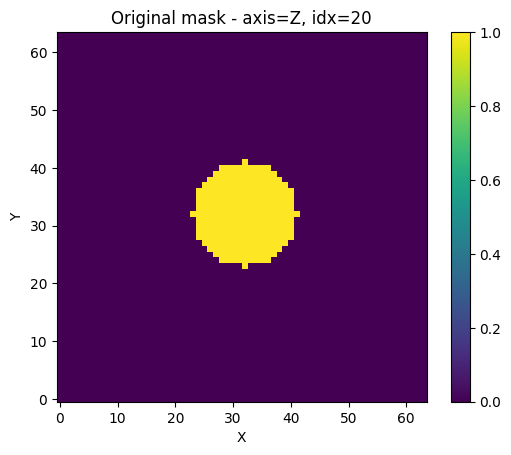

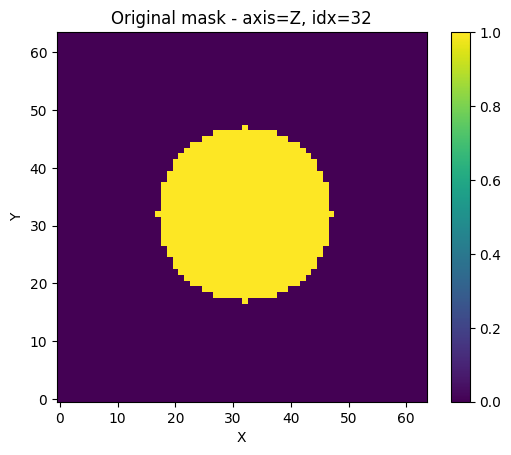

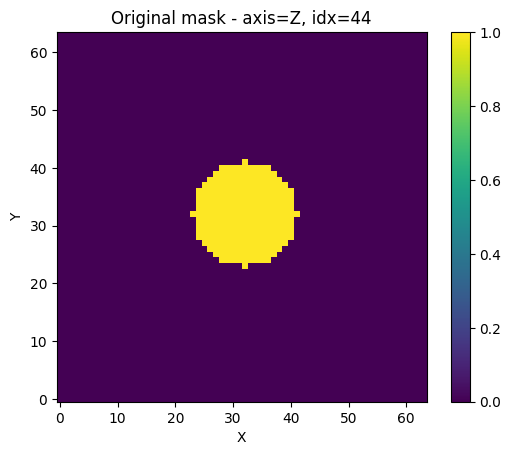

In [11]:
from data import mask_to_sdf, sdf_to_mask

# --- generate pseudo binary mask ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mask = make_sphere_mask(shape=(64, 64, 64), radius=15.0, device=device)  # (1,1,Z,Y,X)

# visualize original mask
plot_slices(mask, axis=0, indices=(20, 32, 44), title_prefix="Original mask - ")

SDF stats: min=-1.000, max=0.239, mean=-0.380, std=0.232


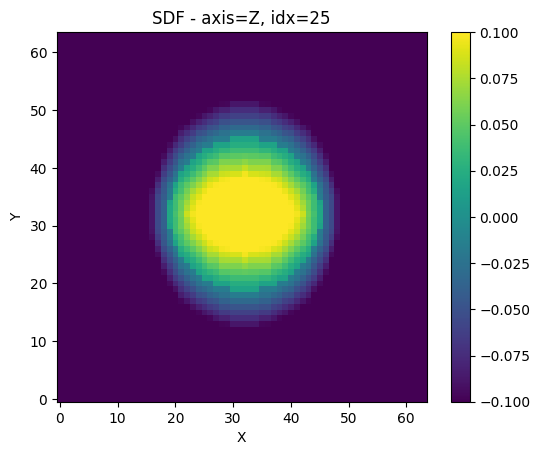

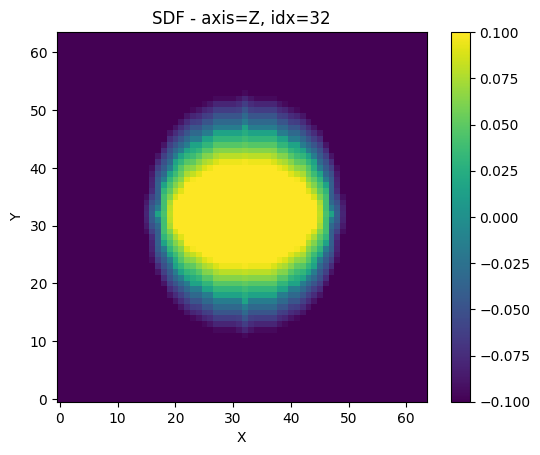

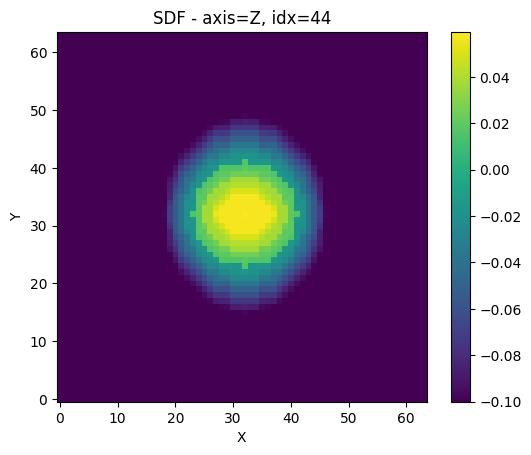

In [12]:
# --- spacing for SDF (mm) ---
spacing = torch.tensor([1.2, 1.0, 2.5], device=device)  # anisotropic example

# --- convert mask -> SDF (uses your function) ---
# assumes: sdf = mask_to_sdf(mask, spacing=spacing, inside_positive=True, normalize=True)
sdf = mask_to_sdf(mask, spacing=spacing, inside_positive=True, normalize=True)

sdf_m = torch.clamp(sdf, -0.1, 0.1)  # for visualization
# print stats of sdf
print(
    f"SDF stats: min={sdf.min().item():.3f}, max={sdf.max().item():.3f}, mean={sdf.mean().item():.3f}, std={sdf.std().item():.3f}"
)
# visualize SDF
plot_slices(sdf_m, axis=0, indices=(25, 32, 44), title_prefix="SDF - ")

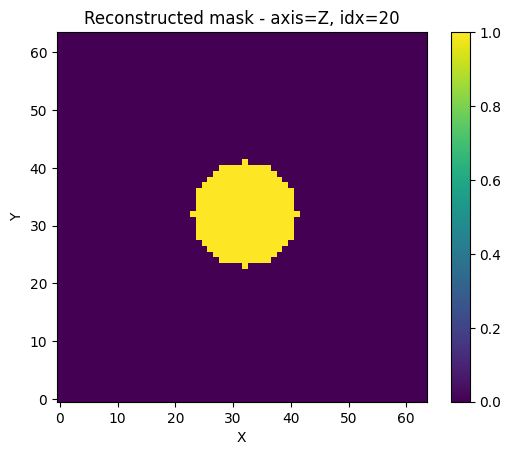

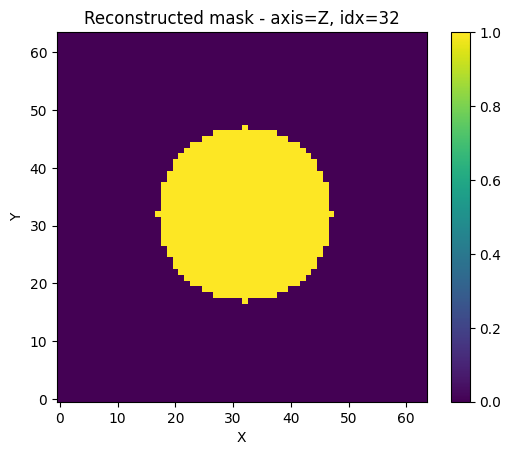

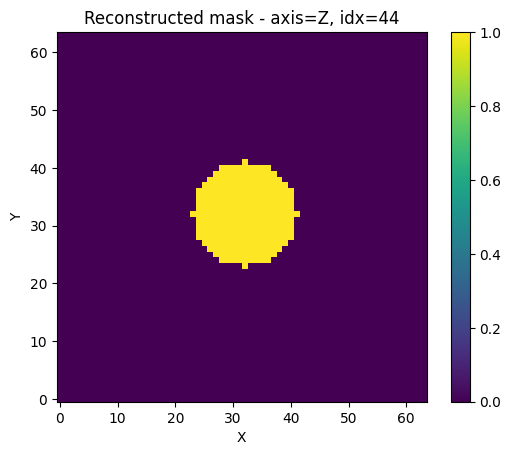

Mask shape: (1, 1, 64, 64, 64) | SDF shape: (1, 1, 64, 64, 64) | Reconstructed: (1, 1, 64, 64, 64)
Dice(original, reconstructed) = 1.000000


In [13]:
# --- convert SDF -> mask (uses your function) ---
# assumes: mask_rec = sdf_to_mask(sdf, inside_positive=True, zero_level=0.0, multi_label=False)
mask_rec = sdf_to_mask(sdf, inside_positive=True, zero_level=0.0, multi_label=False)

# visualize reconstructed mask
plot_slices(
    mask_rec, axis=0, indices=(20, 32, 44), title_prefix="Reconstructed mask - "
)

# --- Dice vs original ---
dsc = dice_coeff(mask, mask_rec)
print(
    f"Mask shape: {tuple(mask.shape)} | SDF shape: {tuple(sdf.shape)} | Reconstructed: {tuple(mask_rec.shape)}"
)
print(f"Dice(original, reconstructed) = {dsc:.6f}")

In [14]:
cache_pt = "/data/usr/yb107/colon_data/cache_mobina_mixed_colon_dataset/c255f40ff6fc9ecdaf8a25d07fc2590a.pt"
data = torch.load(cache_pt, weights_only=False)
image, label = data["image"].squeeze(), data["label"].squeeze()

# Stats
print(
    f"Image stats: min={image.min().item():.3f}, max={image.max().item():.3f}, mean={image.mean().item():.3f}, std={image.std().item():.3f}"
)
print(
    f"Label stats: min={label.min().item():.3f}, max={label.max().item():.3f}, mean={label.mean().item():.3f}, std={label.std().item():.3f}"
)
# SAve them as nii.gz with spacing 1.0, 1.0, 2.5
# import nibabel as nib
# import numpy as np

# nib.save(
#     nib.Nifti1Image(image.cpu().numpy(), affine=np.diag([1.0, 1.0, 2.5, 1.0])),
#     "debug_image.nii.gz",
# )
# nib.save(
#     nib.Nifti1Image(label.cpu().numpy(), affine=np.diag([1.0, 1.0, 2.5, 1.0])),
#     "debug_label.nii.gz",
# )

Image stats: min=-1.000, max=0.253, mean=-0.265, std=0.232
Label stats: min=-1.000, max=0.094, mean=-0.330, std=0.200


In [29]:
from loss import SoftSkeletonize
import nibabel as nib

label12_path = "/home/yb107/cvpr2025/DukeDiffSeg/outputs/diffunet-binary-colon/4.17/val_outputs_ddim_50/Patient_00297_Study_16620_Series_03_label.nii.gz"

skeletonizer = SoftSkeletonize(num_iter=10)

label12_img = nib.load(label12_path)
label12 = (
    torch.from_numpy(label12_img.get_fdata()).float().unsqueeze(0).unsqueeze(0).cuda()
)
skeleton_label12 = skeletonizer(label12)
# skeleton_label12 = skeletonizer.soft_dilate(skeleton_label12)
skeleton_label12 = skeleton_label12.squeeze()
print(skeleton_label12.shape)
# visualize skeleton as nii.gz
nib.save(
    nib.Nifti1Image(skeleton_label12.cpu().numpy(), affine=label12_img.affine),
    "debug_skeleton_label297.nii.gz",
)

torch.Size([96, 96, 96])


## Analyze SDF

In [4]:
import torch.nn.functional as F


def gradients_3d(x, sx, sy, sz):
    # central differences, Neumann padding
    xpad = F.pad(x, (1, 1, 1, 1, 1, 1), mode="replicate")
    dx = (xpad[:, :, 2:, 1:-1, 1:-1] - xpad[:, :, 0:-2, 1:-1, 1:-1]) / (2.0 * sx)
    dy = (xpad[:, :, 1:-1, 2:, 1:-1] - xpad[:, :, 1:-1, 0:-2, 1:-1]) / (2.0 * sy)
    dz = (xpad[:, :, 1:-1, 1:-1, 2:] - xpad[:, :, 1:-1, 1:-1, 0:-2]) / (2.0 * sz)
    return dx, dy, dz


def surface_area_from_sdf(phi_mm, spacing, eps_mm=None):
    sx, sy, sz = spacing
    if eps_mm is None:
        eps_mm = (sx**2 + sy**2 + sz**2) ** 0.5  # ~1 voxel diag in mm
    dx, dy, dz = gradients_3d(phi_mm, sx, sy, sz)
    grad_mag = (dx * dx + dy * dy + dz * dz + 1e-12).sqrt()
    delta = (eps_mm / (eps_mm**2 + phi_mm**2)) / torch.pi
    voxel_vol = sx * sy * sz
    return (delta * grad_mag).sum(dim=(2, 3, 4)) * voxel_vol  # (B,1)->(B,)

In [22]:
# read SDF from a nii.gz file
import nibabel as nib
import torch
import torch.nn as nn
import math
from data import mask_to_sdf, sdf_to_mask


sdf_paths = [
    # Good one
    "/home/yb107/cvpr2025/DukeDiffSeg/outputs/diffunet-binary-colon/4.26/inference_c_grade592/Patient_00175_Study_88441_Series_03_pred.nii.gz",
    # Broken one
    "/home/yb107/cvpr2025/DukeDiffSeg/outputs/diffunet-binary-colon/4.26/inference_c_grade602/Patient_00175_Study_88441_Series_03_pred.nii.gz",
    # GT
    "/home/yb107/cvpr2025/DukeDiffSeg/outputs/diffunet-binary-colon/4.16/inference__c_grade/Patient_00175_Study_88441_Series_03_label.nii.gz",
]

imgs = [nib.load(p) for p in sdf_paths]

# sdf = torch.from_numpy(sdf_img.get_fdata()).float()
img_datas = [torch.from_numpy(img.get_fdata()).float() for img in imgs]
sdfs = [
    mask_to_sdf(
        img_data.unsqueeze(0).unsqueeze(0).cuda(device=2),
        spacing=(1.0, 1.0, 2.0),
        inside_positive=True,
        normalize=True,
    ).squeeze()
    for img_data in img_datas
]

# Unique Values
surface_masks = [sdf.abs() < 0.1 for sdf in sdfs]
for i, surface_mask in enumerate(surface_masks):
    print(f"Surface Mask Volume (voxels) for image {i}: {surface_mask.sum().item()}")
# sdf_only_surface = sdf * surface_mask
# print(f"Surface mask unique values: {sdf_only_surface.unique()}")

surface_area_from_sdfs = [
    surface_area_from_sdf(
        sdf.unsqueeze(0).unsqueeze(0).cuda(), spacing=(1.0, 1.0, 2.0)
    ).item()
    for sdf in sdfs
]
for i, sa in enumerate(surface_area_from_sdfs):
    print(f"Surface Area from SDF for image {i}: {sa:.3f} mm^2")

# SAve the surface mask as nii.gz
# nib.save(
#     nib.Nifti1Image(sdf_only_surface.cpu().numpy(), affine=sdf_img.affine),
#     "debug_sdf_surface.nii.gz",
# )

Surface Mask Volume (voxels) for image 0: 164642
Surface Mask Volume (voxels) for image 1: 163769
Surface Mask Volume (voxels) for image 2: 114116
Surface Area from SDF for image 0: 2976.890 mm^2
Surface Area from SDF for image 1: 3021.345 mm^2
Surface Area from SDF for image 2: 2745.328 mm^2


In [20]:
# ---- helpers you already have (unchanged) ----
def _as_batched_spacing(spacing, B, device, dtype):
    sp = torch.as_tensor(spacing, device=device, dtype=dtype)
    if sp.ndim == 1:
        sp = sp.unsqueeze(0).expand(B, -1)
    assert sp.shape == (B, 3)
    sx = sp[:, 0].view(B, 1, 1, 1, 1)  # spacing along D
    sy = sp[:, 1].view(B, 1, 1, 1, 1)  # spacing along H
    sz = sp[:, 2].view(B, 1, 1, 1, 1)  # spacing along W
    return sx, sy, sz


def gradients_3d_batched(x, sx, sy, sz):
    xpad = F.pad(x, (1, 1, 1, 1, 1, 1), mode="replicate")
    dx = (xpad[:, :, 2:, 1:-1, 1:-1] - xpad[:, :, 0:-2, 1:-1, 1:-1]) / (2.0 * sx)
    dy = (xpad[:, :, 1:-1, 2:, 1:-1] - xpad[:, :, 1:-1, 0:-2, 1:-1]) / (2.0 * sy)
    dz = (xpad[:, :, 1:-1, 1:-1, 2:] - xpad[:, :, 1:-1, 1:-1, 0:-2]) / (2.0 * sz)
    return dx, dy, dz


# ---- NEW: surface area when phi is NORMALIZED ([-1,1]) ----
def surface_area_from_sdf_normalized(phi_norm, spacing, eps_mm=None, tau_mm=None):
    """
    phi_norm: (B,1,D,H,W), normalized SDF in arbitrary units (e.g., [-1,1])
    spacing:  (3,) or (B,3) in mm/voxel, ordered (sD, sH, sW)
    eps_mm:   smoothing width ε in mm for delta; default ~ one voxel diagonal (per sample)
    tau_mm:   band half-width in mm used to estimate the scale; default ~ one voxel diagonal

    Returns: (B,) surface areas in mm^2
    """
    assert phi_norm.ndim == 5 and phi_norm.size(1) == 1
    B = phi_norm.size(0)
    device, dtype = phi_norm.device, phi_norm.dtype
    sD, sH, sW = _as_batched_spacing(spacing, B, device, dtype)
    voxel_vol = sD * sH * sW

    # default widths in mm
    vox_diag_mm = torch.sqrt(sD**2 + sH**2 + sW**2)  # (B,1,1,1,1)
    if eps_mm is None:
        eps_mm = vox_diag_mm  # ~1 voxel diagonal
    if tau_mm is None:
        tau_mm = vox_diag_mm  # band to estimate scale

    # Gradients of normalized SDF w.r.t. WORLD coords (mm)
    dx, dy, dz = gradients_3d_batched(phi_norm, sD, sH, sW)
    grad_mag_norm = torch.sqrt(
        dx * dx + dy * dy + dz * dz + 1e-12
    )  # ≈ 1/s near interface

    # Estimate per-sample scale s_hat so that |∇phi_mm| ≈ 1 in band:
    # Need the band in NORMALIZED units: tau_norm = tau_mm / s_hat (implicit).
    # We solve by fixed-point: start with s_hat=1, refine a couple times.
    s_hat = torch.ones((B, 1, 1, 1, 1), device=device, dtype=dtype)
    for _ in range(2):  # 2 iterations are enough in practice
        tau_norm = tau_mm / s_hat
        band = (phi_norm.abs() <= tau_norm).float()
        denom = band.sum(dim=(2, 3, 4), keepdim=True).clamp_min(1.0)
        g_mean = (grad_mag_norm * band).sum(
            dim=(2, 3, 4), keepdim=True
        ) / denom  # ≈ 1/s
        s_hat = (1.0 / g_mean).clamp(min=1e-6)

    # Either de-normalize phi, or keep normalized and scale epsilon; both are equivalent.
    # We'll KEEP phi normalized and scale epsilon: eps_norm = eps_mm / s_hat
    eps_norm = eps_mm / s_hat

    # Delta_ε*(phi_norm) * |∇phi_norm|
    delta = (eps_norm / (eps_norm**2 + phi_norm**2)) / math.pi
    sa = (delta * grad_mag_norm).sum(dim=(2, 3, 4)) * voxel_vol.squeeze(-1).squeeze(
        -1
    ).squeeze(-1)
    return sa.squeeze(1)  # (B,)


# volume function unchanged (expects mask/prob and spacing in mm)
def volume_from_mask_batched(mask_or_prob, spacing):
    assert mask_or_prob.ndim == 5 and mask_or_prob.size(1) == 1
    B = mask_or_prob.size(0)
    sD, sH, sW = _as_batched_spacing(
        spacing, B, mask_or_prob.device, mask_or_prob.dtype
    )
    voxel_vol = sD * sH * sW
    vol = mask_or_prob.sum(dim=(2, 3, 4)) * voxel_vol.squeeze(-1).squeeze(-1).squeeze(
        -1
    )
    return vol.squeeze(1)


def loss_isoperimetric(area_mm2, volume_mm3, alpha=1e-6, beta=1e-6, reduction="mea"):
    # add small unit-consistent stabilizers
    a = area_mm2 + alpha
    v = volume_mm3 + beta
    # minimize A^3 / V^2  ==  minimize 3*log(A) - 2*log(V)
    per_sample = 3.0 * torch.log(a) - 2.0 * torch.log(v)
    if reduction == "mean":
        return per_sample.mean()
    elif reduction == "sum":
        return per_sample.sum()
    else:
        return per_sample  # no reduction

In [23]:
loss_geos = [
    loss_isoperimetric(
        surface_area_from_sdf_normalized(
            sdf.unsqueeze(0).unsqueeze(0).cuda(), spacing=(1.0, 1.0, 2.0)
        ),
        volume_from_mask_batched(
            (sdf > 0).float().unsqueeze(0).unsqueeze(0).cuda(), spacing=(1.0, 1.0, 2.0)
        ),
        alpha=1e-6,
        beta=1e-6,
        reduction="mean",
    )
    for sdf in sdfs
]

for i, loss_geo in enumerate(loss_geos):
    print(f"Isoperimetric Loss for image {sdf_paths[i]}: {loss_geo.item():.6f}")

Isoperimetric Loss for image /home/yb107/cvpr2025/DukeDiffSeg/outputs/diffunet-binary-colon/4.26/inference_c_grade592/Patient_00175_Study_88441_Series_03_pred.nii.gz: 6.528973
Isoperimetric Loss for image /home/yb107/cvpr2025/DukeDiffSeg/outputs/diffunet-binary-colon/4.26/inference_c_grade602/Patient_00175_Study_88441_Series_03_pred.nii.gz: 6.623880
Isoperimetric Loss for image /home/yb107/cvpr2025/DukeDiffSeg/outputs/diffunet-binary-colon/4.16/inference__c_grade/Patient_00175_Study_88441_Series_03_label.nii.gz: 7.371283


Isoperimetric Loss for image /home/yb107/cvpr2025/DukeDiffSeg/outputs/diffunet-binary-colon/4.26/inference_c_grade602/Patient_00135_Study_03256_Series_03_pred.nii.gz: 6.694994 # 2 components but better
Isoperimetric Loss for image /home/yb107/cvpr2025/DukeDiffSeg/outputs/diffunet-binary-colon/4.16/inference__c_grade/Patient_00135_Study_03256_Series_03_pred.nii.gz: 7.125637 # BAd pred
Isoperimetric Loss for image /home/yb107/cvpr2025/DukeDiffSeg/outputs/diffunet-binary-colon/4.16/inference__c_grade/Patient_00135_Study_03256_Series_03_label.nii.gz: 7.004297 # ground truth

Isoperimetric Loss for image /home/yb107/cvpr2025/DukeDiffSeg/outputs/diffunet-binary-colon/4.16/inference_c_grade4_gs_0.7/Patient_00009_Study_74723_Series_03_pred.nii.gz: 6.915335 # Connected and Good 
Isoperimetric Loss for image /home/yb107/cvpr2025/DukeDiffSeg/outputs/diffunet-binary-colon/4.26/inference_c_grade592/Patient_00009_Study_74723_Series_03_pred.nii.gz: 6.203228 # Connected But BAd
Isoperimetric Loss for image /home/yb107/cvpr2025/DukeDiffSeg/outputs/diffunet-binary-colon/4.26/inference_c_grade602/Patient_00009_Study_74723_Series_03_pred.nii.gz: 6.416630 # Connected but not as good
Isoperimetric Loss for image /home/yb107/cvpr2025/DukeDiffSeg/outputs/diffunet-binary-colon/4.8/test_outputs/Patient_00009_Study_74723_Series_03_label.nii.gz: 7.547892 # Original


Isoperimetric Loss for image /home/yb107/cvpr2025/DukeDiffSeg/outputs/diffunet-binary-colon/4.26/inference_c_grade592/Patient_00175_Study_88441_Series_03_pred.nii.gz: 6.528973 # Single Componenet
Isoperimetric Loss for image /home/yb107/cvpr2025/DukeDiffSeg/outputs/diffunet-binary-colon/4.26/inference_c_grade602/Patient_00175_Study_88441_Series_03_pred.nii.gz: 6.623880 # multi component
Isoperimetric Loss for image /home/yb107/cvpr2025/DukeDiffSeg/outputs/diffunet-binary-colon/4.16/inference__c_grade/Patient_00175_Study_88441_Series_03_label.nii.gz: 7.371283 # Ground truth

In [46]:
import cc3d
import numpy as np


len(img_datas)
# img_datas[0].unique()
labels = cc3d.connected_components(img_datas[1].to(torch.uint8), connectivity=6)
sizes = np.bincount(labels.ravel())
comps = np.where(sizes > 1000)[0]  # components larger than 1000 voxels
comps, sizes

(array([0, 1, 2, 6]),
 array([827233,  12204,  25527,     40,      2,    810,  18920]))